# Stereoisomer testing on ChiENN - enantiomers/diastereomers (multiple centers)

## Importing section

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys
sys.path.append("../../../../")
from ptgnn.features.chienn.molecule3d import smiles_to_data_with_circle_index
from ptgnn.model.chienn.chienn_layer import ChiENNLayer
from ptgnn.loading.chienn_collate import collate_with_circle_index
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.transform import edge_graph_transform, vertex_graph_transform
from ptgnn.model.modules.ptree.complex_ptree_layer import ComplexPtreeLayer

## Define SMILES strings

In [2]:
smiles_list = [
    "O=C[C@](O)([H])[C@]([H])(O)CO",
    # "OC[C@](O)([H])[C@]([H])(O)C=O",
    
    "O=C[C@@](O)([H])[C@]([H])(O)CO",
    # "OC[C@](O)([H])[C@@]([H])(O)C=O",
    
    "O=C[C@](O)([H])[C@@]([H])(O)CO",
    # "OC[C@@](O)([H])[C@]([H])(O)C=O",
    
    "O=C[C@@](O)([H])[C@@]([H])(O)CO",
    # "OC[C@@](O)([H])[C@@]([H])(O)C=O",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

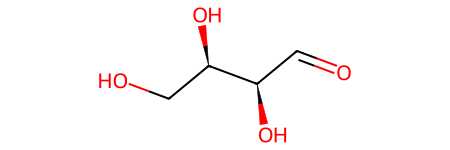

[(2, 'S'), (4, 'R')]
Bond 0 stereo: STEREONONE


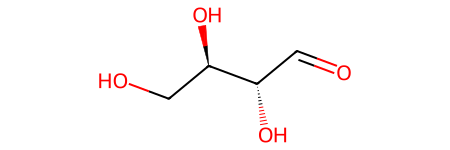

[(2, 'R'), (4, 'R')]
Bond 0 stereo: STEREONONE


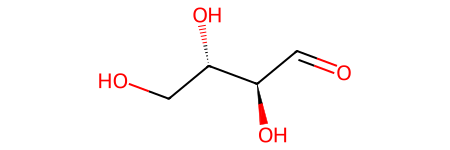

[(2, 'S'), (4, 'S')]
Bond 0 stereo: STEREONONE


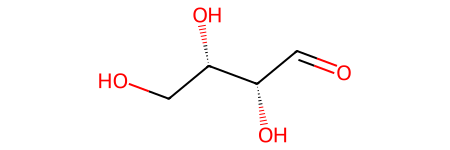

[(2, 'R'), (4, 'S')]
Bond 0 stereo: STEREONONE


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    edge_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': False,
            'chiral_center_selective': True,
            'chiral_center_select_potential': False,
            'multi_stereo_center_dia': True
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
d = data_list[0]
display(d.ptree, d.initial_map)
for i in range(d.num_layer):
    display(f"layer: {i}")
    display(d[f"layer{i}_order_matrix"], d[f"layer{i}_type_mask"], d[f"layer{i}_pooling"])

['{"S": [0, 1]}',
 '{"S": [1, 0, {"P": [3, 5]}]}',
 '{"S": [2, 3, {"P": [0, 5]}]}',
 '{"S": [3, 2, {"P": [7, 9, 11]}]}',
 '{"S": [4, 5, {"P": [0, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"P": [2, 11, 9]}]}',
 '{"S": [7, 6, {"P": [13]}]}',
 '{"P": [{"P": [{"Z": [15, 19, 17]}, {"Z": [15, 19, 17]}]}, {"P": [{"Z": [17, 19, 15]}, {"Z": [17, 19, 15]}]}]}',
 '{"P": [{"P": [{"Z": [15, 19, 17]}, {"Z": [15, 19, 17]}]}, {"P": [{"Z": [17, 19, 15]}, {"Z": [17, 19, 15]}]}]}',
 '{"S": [10, 11, {"P": [2, 9, 7]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"P": [6]}]}',
 '{"S": [13, 12]}',
 '{"S": [14, 15, {"P": [8, 17, 19]}]}',
 '{"S": [15, 14, {"P": [21]}]}',
 '{"S": [16, 17, {"P": [8, 19, 15]}]}',
 '{"S": [17, 16, {"P": [23, 27, 25]}]}',
 '{"S": [18, 19, {"P": [8, 15, 17]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"P": [14]}]}',
 '{"S": [21, 20]}',
 '{"S": [22, 23, {"P": [16, 25, 27]}]}',
 '{"S": [23, 22, {"P": [29]}]}',
 '{"S": [24, 25, {"P": [16, 27, 23]}]}',
 '{"S": [25, 24]}',
 '{"S": [26, 27, {"P

tensor([ 0,  1,  1,  0,  3,  5,  2,  3,  0,  5,  3,  2,  7,  9, 11,  4,  5,  0,
         3,  5,  4,  6,  7,  2, 11,  9,  7,  6, 13, 15, 19, 17, 15, 19, 17, 17,
        19, 15, 17, 19, 15, 15, 19, 17, 15, 19, 17, 17, 19, 15, 17, 19, 15, 10,
        11,  2,  9,  7, 11, 10, 12, 13,  6, 13, 12, 14, 15,  8, 17, 19, 15, 14,
        21, 16, 17,  8, 19, 15, 17, 16, 23, 27, 25, 18, 19,  8, 15, 17, 19, 18,
        20, 21, 14, 21, 20, 22, 23, 16, 25, 27, 23, 22, 29, 24, 25, 16, 27, 23,
        25, 24, 26, 27, 16, 23, 25, 27, 26, 28, 29, 22, 29, 28])

'layer: 0'

[[tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
            14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
            28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
            42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
            56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
            70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
            84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
            98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
           112, 113, 114, 115, 116, 117, 118, 119, 120, 121],
          [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
            -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
            -1,  30,  31,  29,  33,  34,  32,  36,  37,  35,  39,  40,  38,  42,
            43,  41,  45,  46,  44,  48,  49,  

[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0])]]

[[tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
           14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
           28,  29,  29,  29,  30,  30,  30,  31,  31,  31,  32,  32,  32,  33,
           33,  33,  34,  34,  34,  35,  35,  35,  36,  36,  36,  37,  38,  39,
           40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
           54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
           68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
           82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
           96,  97,  98,  99, 100, 101, 102, 103, 104, 105])]]

'layer: 1'

[[tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
            14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
            28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
            42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
            56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
            70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
            84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
            98,  99, 100, 101, 102, 103, 104, 105],
          [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
            -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
            -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
            -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
            -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  

[[tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
          1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
          0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
          0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
          1, 1, 1, 0, 0, 0, 0, 1, 0, 0])]]

[[tensor([ 0,  1,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 10, 10, 11, 12, 13,
          13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25,
          25, 26, 27, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 38, 38,
          39, 40, 41, 42, 43, 44, 44, 44, 45, 46, 47, 47, 47, 48, 49, 50, 50, 50,
          51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 60, 61, 62, 63, 64, 65, 66,
          66, 66, 67, 68, 69, 70, 71, 71, 71, 72, 73, 74, 75, 76, 77, 78])]]

'layer: 2'

[[tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, -1, 11, -1, -1, 14, -1, 16, -1,
           -1, 19, -1, -1, 22, 23, 24, 25, 26, -1, -1, 29, -1, 31, -1, -1, 34, -1,
           36, -1, -1, 39, -1, -1, 42, -1, -1, 45, -1, -1, 48, -1, -1, 51, -1, 53,
           -1, -1, 56, -1, 58, -1, -1, 61, -1, -1, 64, -1, -1, 67, -1, 69, -1, -1,
           72, -1, 74, -1, -1, 77, -1],
          [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, -1, 12, -1, -1, 15, -1, 17, -1,
           -1, 20, -1, -1, -1, -1, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35, -1,
           37, -1, -1, 40, -1, -1, 43, -1, -1, 46, -1, -1, 49, -1, -1, 52, -1, 54,
           -1, -1, 57, -1, 59, -1, -1, 62, -1, -1, 65, -1, -1, 68, -1, 70, -1, -1,
           73, -1, 75, -1, -1, 78, -1],
          [-1, -1,  4, -1, -1,  7, -1, -1, 10, -1, -1, 13, -1, -1, -1, -1, 18, -1,
           -1, 21, -1, -1, -1, -1, -1, -1, 28, -1, -1, -1, -1, 33, -1, -1, -1, -1,
           38, -1, -1, 41, -1, -1, 44, -1, -1, 47, -1, -1, 50, -1, -1, -1, -1, 55,
       

[[tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
          1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
          3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
          3, 3, 3, 3, 3, 3, 3])]]

[[tensor([ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,
           6,  7,  7,  7,  8,  8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13,
          14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 20,
          20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26,
          27, 27, 28, 28, 28, 29, 29])]]

In [9]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[30, 93], edge_index=[2, 78], edge_attr=[78, 57], pos=[30, 6], parallel_node_index=[30], circle_index=[30], ptree=[30], initial_map=[122], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=3, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1], layer2_order_matrix=[1], layer2_type_mask=[1], layer2_pooling=[1])
['{"S": [0, 1]}', '{"S": [1, 0, {"P": [3, 5]}]}', '{"S": [2, 3, {"P": [0, 5]}]}', '{"S": [3, 2, {"P": [7, 9, 11]}]}', '{"S": [4, 5, {"P": [0, 3]}]}', '{"S": [5, 4]}', '{"S": [6, 7, {"P": [2, 11, 9]}]}', '{"S": [7, 6, {"P": [13]}]}', '{"P": [{"P": [{"Z": [15, 19, 17]}, {"Z": [15, 19, 17]}]}, {"P": [{"Z": [17, 19, 15]}, {"Z": [17, 19, 15]}]}]}', '{"P": [{"P": [{"Z": [15, 19, 17]}, {"Z": [15, 19, 17]}]}, {"P": [{"Z": [17, 19, 15]}, {"Z": [17, 19, 15]}]}]}', '{"S": [10, 11, {"P": [2, 9, 7]}]}', '{"S": [11, 10]}', '{"S": [12, 13, {"P": [6]}]}', '{"S": [13, 12]}', '{"S": [14, 15, {"P": [8, 17, 19]}]}', '{"S": [15, 14, {"P": [21]}]}', '{"S

## Create Model

In [10]:
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

model = AdvancedPermutationTreeLayer(
    hidden_dim=93,
    k=k,
    batch_norm=True
)

In [11]:
import torch
from ptgnn.model.modules.custom_wrapper import CustomWrapper

k = 3

modules_list = [
    CustomWrapper(AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k
    ))
    for _ in range(2)
] + [
    AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (elu): ELU(alpha=1.0)
      (batch_norm): BatchNorm1d(93, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Li

## Create batches

In [12]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [13]:
for idx, batch in enumerate(batch_list):
    display(f"Batch: {idx}")
    display(batch.ptree)
    display(batch.initial_map)
    for layer_idx in range(batch.num_layer):
        display(f"Layer: {layer_idx}")
        display(
            batch[f"layer{layer_idx}_order_matrix"],
            batch[f"layer{layer_idx}_type_mask"],
            batch[f"layer{layer_idx}_pooling"]
        )

'Batch: 0'

['{"S": [0, 1]}',
 '{"S": [1, 0, {"P": [3, 5]}]}',
 '{"S": [2, 3, {"P": [0, 5]}]}',
 '{"S": [3, 2, {"P": [7, 9, 11]}]}',
 '{"S": [4, 5, {"P": [0, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"P": [2, 11, 9]}]}',
 '{"S": [7, 6, {"P": [13]}]}',
 '{"P": [{"P": [{"Z": [15, 19, 17]}, {"Z": [15, 19, 17]}]}, {"P": [{"Z": [17, 19, 15]}, {"Z": [17, 19, 15]}]}]}',
 '{"P": [{"P": [{"Z": [15, 19, 17]}, {"Z": [15, 19, 17]}]}, {"P": [{"Z": [17, 19, 15]}, {"Z": [17, 19, 15]}]}]}',
 '{"S": [10, 11, {"P": [2, 9, 7]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"P": [6]}]}',
 '{"S": [13, 12]}',
 '{"S": [14, 15, {"P": [8, 17, 19]}]}',
 '{"S": [15, 14, {"P": [21]}]}',
 '{"S": [16, 17, {"P": [8, 19, 15]}]}',
 '{"S": [17, 16, {"P": [23, 27, 25]}]}',
 '{"S": [18, 19, {"P": [8, 15, 17]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"P": [14]}]}',
 '{"S": [21, 20]}',
 '{"S": [22, 23, {"P": [16, 25, 27]}]}',
 '{"S": [23, 22, {"P": [29]}]}',
 '{"S": [24, 25, {"P": [16, 27, 23]}]}',
 '{"S": [25, 24]}',
 '{"S": [26, 27, {"P

tensor([ 0,  1,  1,  0,  3,  5,  2,  3,  0,  5,  3,  2,  7,  9, 11,  4,  5,  0,
         3,  5,  4,  6,  7,  2, 11,  9,  7,  6, 13, 15, 19, 17, 15, 19, 17, 17,
        19, 15, 17, 19, 15, 15, 19, 17, 15, 19, 17, 17, 19, 15, 17, 19, 15, 10,
        11,  2,  9,  7, 11, 10, 12, 13,  6, 13, 12, 14, 15,  8, 17, 19, 15, 14,
        21, 16, 17,  8, 19, 15, 17, 16, 23, 27, 25, 18, 19,  8, 15, 17, 19, 18,
        20, 21, 14, 21, 20, 22, 23, 16, 25, 27, 23, 22, 29, 24, 25, 16, 27, 23,
        25, 24, 26, 27, 16, 23, 25, 27, 26, 28, 29, 22, 29, 28])

'Layer: 0'

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  30,  31,  29,  33,  34,  32,  36,  37,  35,  39,  40,  38,  42,
          43,  41,  45,  46,  44,  48,  49,  47,  51,  52,  50,  -1,  -

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  29,  29,  30,  30,  30,  31,  31,  31,  32,  32,  32,  33,
         33,  33,  34,  34,  34,  35,  35,  35,  36,  36,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105])

'Layer: 1'

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
  

tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0])

tensor([ 0,  1,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 10, 10, 11, 12, 13,
        13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25,
        25, 26, 27, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 38, 38,
        39, 40, 41, 42, 43, 44, 44, 44, 45, 46, 47, 47, 47, 48, 49, 50, 50, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 60, 61, 62, 63, 64, 65, 66,
        66, 66, 67, 68, 69, 70, 71, 71, 71, 72, 73, 74, 75, 76, 77, 78])

'Layer: 2'

tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, -1, 22, 23, 24, 25, 26, -1, -1, 29, -1, 31, -1, -1, 34, -1,
         36, -1, -1, 39, -1, -1, 42, -1, -1, 45, -1, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1, 58, -1, -1, 61, -1, -1, 64, -1, -1, 67, -1, 69, -1, -1,
         72, -1, 74, -1, -1, 77, -1],
        [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, -1, -1, -1, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35, -1,
         37, -1, -1, 40, -1, -1, 43, -1, -1, 46, -1, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1, 59, -1, -1, 62, -1, -1, 65, -1, -1, 68, -1, 70, -1, -1,
         73, -1, 75, -1, -1, 78, -1],
        [-1, -1,  4, -1, -1,  7, -1, -1, 10, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, 21, -1, -1, -1, -1, -1, -1, 28, -1, -1, -1, -1, 33, -1, -1, -1, -1,
         38, -1, -1, 41, -1, -1, 44, -1, -1, 47, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1, 60, -1, 

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
        1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  7,  8,  8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13,
        14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26,
        27, 27, 28, 28, 28, 29, 29])

'Batch: 1'

['{"S": [0, 1]}',
 '{"S": [1, 0, {"P": [3, 5]}]}',
 '{"S": [2, 3, {"P": [0, 5]}]}',
 '{"S": [3, 2, {"P": [7, 11, 9]}]}',
 '{"S": [4, 5, {"P": [0, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"P": [2, 9, 11]}]}',
 '{"S": [7, 6, {"P": [13]}]}',
 '{"P": [{"P": [{"Z": [15, 19, 17]}, {"Z": [15, 19, 17]}]}, {"P": [{"Z": [17, 19, 15]}, {"Z": [17, 19, 15]}]}]}',
 '{"P": [{"P": [{"Z": [15, 19, 17]}, {"Z": [15, 19, 17]}]}, {"P": [{"Z": [17, 19, 15]}, {"Z": [17, 19, 15]}]}]}',
 '{"S": [10, 11, {"P": [2, 7, 9]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"P": [6]}]}',
 '{"S": [13, 12]}',
 '{"S": [14, 15, {"P": [8, 17, 19]}]}',
 '{"S": [15, 14, {"P": [21]}]}',
 '{"S": [16, 17, {"P": [8, 19, 15]}]}',
 '{"S": [17, 16, {"P": [23, 27, 25]}]}',
 '{"S": [18, 19, {"P": [8, 15, 17]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"P": [14]}]}',
 '{"S": [21, 20]}',
 '{"S": [22, 23, {"P": [16, 25, 27]}]}',
 '{"S": [23, 22, {"P": [29]}]}',
 '{"S": [24, 25, {"P": [16, 27, 23]}]}',
 '{"S": [25, 24]}',
 '{"S": [26, 27, {"P

tensor([ 0,  1,  1,  0,  3,  5,  2,  3,  0,  5,  3,  2,  7, 11,  9,  4,  5,  0,
         3,  5,  4,  6,  7,  2,  9, 11,  7,  6, 13, 15, 19, 17, 15, 19, 17, 17,
        19, 15, 17, 19, 15, 15, 19, 17, 15, 19, 17, 17, 19, 15, 17, 19, 15, 10,
        11,  2,  7,  9, 11, 10, 12, 13,  6, 13, 12, 14, 15,  8, 17, 19, 15, 14,
        21, 16, 17,  8, 19, 15, 17, 16, 23, 27, 25, 18, 19,  8, 15, 17, 19, 18,
        20, 21, 14, 21, 20, 22, 23, 16, 25, 27, 23, 22, 29, 24, 25, 16, 27, 23,
        25, 24, 26, 27, 16, 23, 25, 27, 26, 28, 29, 22, 29, 28])

'Layer: 0'

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  30,  31,  29,  33,  34,  32,  36,  37,  35,  39,  40,  38,  42,
          43,  41,  45,  46,  44,  48,  49,  47,  51,  52,  50,  -1,  -

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  29,  29,  30,  30,  30,  31,  31,  31,  32,  32,  32,  33,
         33,  33,  34,  34,  34,  35,  35,  35,  36,  36,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105])

'Layer: 1'

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
  

tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0])

tensor([ 0,  1,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 10, 10, 11, 12, 13,
        13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25,
        25, 26, 27, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 38, 38,
        39, 40, 41, 42, 43, 44, 44, 44, 45, 46, 47, 47, 47, 48, 49, 50, 50, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 60, 61, 62, 63, 64, 65, 66,
        66, 66, 67, 68, 69, 70, 71, 71, 71, 72, 73, 74, 75, 76, 77, 78])

'Layer: 2'

tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, -1, 22, 23, 24, 25, 26, -1, -1, 29, -1, 31, -1, -1, 34, -1,
         36, -1, -1, 39, -1, -1, 42, -1, -1, 45, -1, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1, 58, -1, -1, 61, -1, -1, 64, -1, -1, 67, -1, 69, -1, -1,
         72, -1, 74, -1, -1, 77, -1],
        [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, -1, -1, -1, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35, -1,
         37, -1, -1, 40, -1, -1, 43, -1, -1, 46, -1, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1, 59, -1, -1, 62, -1, -1, 65, -1, -1, 68, -1, 70, -1, -1,
         73, -1, 75, -1, -1, 78, -1],
        [-1, -1,  4, -1, -1,  7, -1, -1, 10, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, 21, -1, -1, -1, -1, -1, -1, 28, -1, -1, -1, -1, 33, -1, -1, -1, -1,
         38, -1, -1, 41, -1, -1, 44, -1, -1, 47, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1, 60, -1, 

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
        1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  7,  8,  8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13,
        14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26,
        27, 27, 28, 28, 28, 29, 29])

'Batch: 2'

['{"S": [0, 1]}',
 '{"S": [1, 0, {"P": [3, 5]}]}',
 '{"S": [2, 3, {"P": [0, 5]}]}',
 '{"S": [3, 2, {"P": [7, 9, 11]}]}',
 '{"S": [4, 5, {"P": [0, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"P": [2, 11, 9]}]}',
 '{"S": [7, 6, {"P": [13]}]}',
 '{"P": [{"P": [{"Z": [15, 17, 19]}, {"Z": [15, 17, 19]}]}, {"P": [{"Z": [19, 17, 15]}, {"Z": [19, 17, 15]}]}]}',
 '{"P": [{"P": [{"Z": [15, 17, 19]}, {"Z": [15, 17, 19]}]}, {"P": [{"Z": [19, 17, 15]}, {"Z": [19, 17, 15]}]}]}',
 '{"S": [10, 11, {"P": [2, 9, 7]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"P": [6]}]}',
 '{"S": [13, 12]}',
 '{"S": [14, 15, {"P": [8, 19, 17]}]}',
 '{"S": [15, 14, {"P": [21]}]}',
 '{"S": [16, 17, {"P": [8, 15, 19]}]}',
 '{"S": [17, 16, {"P": [23, 27, 25]}]}',
 '{"S": [18, 19, {"P": [8, 17, 15]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"P": [14]}]}',
 '{"S": [21, 20]}',
 '{"S": [22, 23, {"P": [16, 25, 27]}]}',
 '{"S": [23, 22, {"P": [29]}]}',
 '{"S": [24, 25, {"P": [16, 27, 23]}]}',
 '{"S": [25, 24]}',
 '{"S": [26, 27, {"P

tensor([ 0,  1,  1,  0,  3,  5,  2,  3,  0,  5,  3,  2,  7,  9, 11,  4,  5,  0,
         3,  5,  4,  6,  7,  2, 11,  9,  7,  6, 13, 15, 17, 19, 15, 17, 19, 19,
        17, 15, 19, 17, 15, 15, 17, 19, 15, 17, 19, 19, 17, 15, 19, 17, 15, 10,
        11,  2,  9,  7, 11, 10, 12, 13,  6, 13, 12, 14, 15,  8, 19, 17, 15, 14,
        21, 16, 17,  8, 15, 19, 17, 16, 23, 27, 25, 18, 19,  8, 17, 15, 19, 18,
        20, 21, 14, 21, 20, 22, 23, 16, 25, 27, 23, 22, 29, 24, 25, 16, 27, 23,
        25, 24, 26, 27, 16, 23, 25, 27, 26, 28, 29, 22, 29, 28])

'Layer: 0'

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  30,  31,  29,  33,  34,  32,  36,  37,  35,  39,  40,  38,  42,
          43,  41,  45,  46,  44,  48,  49,  47,  51,  52,  50,  -1,  -

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  29,  29,  30,  30,  30,  31,  31,  31,  32,  32,  32,  33,
         33,  33,  34,  34,  34,  35,  35,  35,  36,  36,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105])

'Layer: 1'

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
  

tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0])

tensor([ 0,  1,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 10, 10, 11, 12, 13,
        13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25,
        25, 26, 27, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 38, 38,
        39, 40, 41, 42, 43, 44, 44, 44, 45, 46, 47, 47, 47, 48, 49, 50, 50, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 60, 61, 62, 63, 64, 65, 66,
        66, 66, 67, 68, 69, 70, 71, 71, 71, 72, 73, 74, 75, 76, 77, 78])

'Layer: 2'

tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, -1, 22, 23, 24, 25, 26, -1, -1, 29, -1, 31, -1, -1, 34, -1,
         36, -1, -1, 39, -1, -1, 42, -1, -1, 45, -1, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1, 58, -1, -1, 61, -1, -1, 64, -1, -1, 67, -1, 69, -1, -1,
         72, -1, 74, -1, -1, 77, -1],
        [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, -1, -1, -1, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35, -1,
         37, -1, -1, 40, -1, -1, 43, -1, -1, 46, -1, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1, 59, -1, -1, 62, -1, -1, 65, -1, -1, 68, -1, 70, -1, -1,
         73, -1, 75, -1, -1, 78, -1],
        [-1, -1,  4, -1, -1,  7, -1, -1, 10, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, 21, -1, -1, -1, -1, -1, -1, 28, -1, -1, -1, -1, 33, -1, -1, -1, -1,
         38, -1, -1, 41, -1, -1, 44, -1, -1, 47, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1, 60, -1, 

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
        1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  7,  8,  8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13,
        14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26,
        27, 27, 28, 28, 28, 29, 29])

'Batch: 3'

['{"S": [0, 1]}',
 '{"S": [1, 0, {"P": [3, 5]}]}',
 '{"S": [2, 3, {"P": [0, 5]}]}',
 '{"S": [3, 2, {"P": [7, 11, 9]}]}',
 '{"S": [4, 5, {"P": [0, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"P": [2, 9, 11]}]}',
 '{"S": [7, 6, {"P": [13]}]}',
 '{"P": [{"P": [{"Z": [15, 17, 19]}, {"Z": [15, 17, 19]}]}, {"P": [{"Z": [19, 17, 15]}, {"Z": [19, 17, 15]}]}]}',
 '{"P": [{"P": [{"Z": [15, 17, 19]}, {"Z": [15, 17, 19]}]}, {"P": [{"Z": [19, 17, 15]}, {"Z": [19, 17, 15]}]}]}',
 '{"S": [10, 11, {"P": [2, 7, 9]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"P": [6]}]}',
 '{"S": [13, 12]}',
 '{"S": [14, 15, {"P": [8, 19, 17]}]}',
 '{"S": [15, 14, {"P": [21]}]}',
 '{"S": [16, 17, {"P": [8, 15, 19]}]}',
 '{"S": [17, 16, {"P": [23, 27, 25]}]}',
 '{"S": [18, 19, {"P": [8, 17, 15]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"P": [14]}]}',
 '{"S": [21, 20]}',
 '{"S": [22, 23, {"P": [16, 25, 27]}]}',
 '{"S": [23, 22, {"P": [29]}]}',
 '{"S": [24, 25, {"P": [16, 27, 23]}]}',
 '{"S": [25, 24]}',
 '{"S": [26, 27, {"P

tensor([ 0,  1,  1,  0,  3,  5,  2,  3,  0,  5,  3,  2,  7, 11,  9,  4,  5,  0,
         3,  5,  4,  6,  7,  2,  9, 11,  7,  6, 13, 15, 17, 19, 15, 17, 19, 19,
        17, 15, 19, 17, 15, 15, 17, 19, 15, 17, 19, 19, 17, 15, 19, 17, 15, 10,
        11,  2,  7,  9, 11, 10, 12, 13,  6, 13, 12, 14, 15,  8, 19, 17, 15, 14,
        21, 16, 17,  8, 15, 19, 17, 16, 23, 27, 25, 18, 19,  8, 17, 15, 19, 18,
        20, 21, 14, 21, 20, 22, 23, 16, 25, 27, 23, 22, 29, 24, 25, 16, 27, 23,
        25, 24, 26, 27, 16, 23, 25, 27, 26, 28, 29, 22, 29, 28])

'Layer: 0'

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  30,  31,  29,  33,  34,  32,  36,  37,  35,  39,  40,  38,  42,
          43,  41,  45,  46,  44,  48,  49,  47,  51,  52,  50,  -1,  -

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  29,  29,  30,  30,  30,  31,  31,  31,  32,  32,  32,  33,
         33,  33,  34,  34,  34,  35,  35,  35,  36,  36,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105])

'Layer: 1'

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
  

tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0])

tensor([ 0,  1,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 10, 10, 11, 12, 13,
        13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25,
        25, 26, 27, 28, 28, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 38, 38,
        39, 40, 41, 42, 43, 44, 44, 44, 45, 46, 47, 47, 47, 48, 49, 50, 50, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 60, 61, 62, 63, 64, 65, 66,
        66, 66, 67, 68, 69, 70, 71, 71, 71, 72, 73, 74, 75, 76, 77, 78])

'Layer: 2'

tensor([[ 0, -1,  2, -1, -1,  5, -1, -1,  8, -1, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, -1, 22, 23, 24, 25, 26, -1, -1, 29, -1, 31, -1, -1, 34, -1,
         36, -1, -1, 39, -1, -1, 42, -1, -1, 45, -1, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1, 58, -1, -1, 61, -1, -1, 64, -1, -1, 67, -1, 69, -1, -1,
         72, -1, 74, -1, -1, 77, -1],
        [ 1, -1,  3, -1, -1,  6, -1, -1,  9, -1, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, -1, -1, -1, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35, -1,
         37, -1, -1, 40, -1, -1, 43, -1, -1, 46, -1, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1, 59, -1, -1, 62, -1, -1, 65, -1, -1, 68, -1, 70, -1, -1,
         73, -1, 75, -1, -1, 78, -1],
        [-1, -1,  4, -1, -1,  7, -1, -1, 10, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, 21, -1, -1, -1, -1, -1, -1, 28, -1, -1, -1, -1, 33, -1, -1, -1, -1,
         38, -1, -1, 41, -1, -1, 44, -1, -1, 47, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1, 60, -1, 

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
        1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  7,  8,  8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13,
        14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26,
        27, 27, 28, 28, 28, 29, 29])

In [14]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all()
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

## Put batches through model

In [15]:
out_list = [
    model(batch)
    for batch in batch_list
]

In [16]:
out_list

[tensor([[ 0.0357, -0.0214,  0.0062,  ..., -0.0175,  0.0119,  0.0044],
         [ 0.0009, -0.0056, -0.0408,  ..., -0.0329, -0.0035,  0.0031],
         [ 0.0289, -0.0097, -0.0115,  ..., -0.0531,  0.0148, -0.0305],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        grad_fn=<IndexPutBackward0>),
 tensor([[ 0.0357, -0.0214,  0.0062,  ..., -0.0175,  0.0119,  0.0044],
         [ 0.0009, -0.0056, -0.0408,  ..., -0.0329, -0.0035,  0.0031],
         [ 0.0289, -0.0097, -0.0115,  ..., -0.0531,  0.0148, -0.0305],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        grad_fn=<IndexPutBackward0>),
 tensor([[ 0.0357, -0.0214,  0.0062,  ...,

## Compare batches

In [17]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True]])

In [18]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True]])

In [19]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[0.0000000e+00, 1.1506054e-05, 7.6212746e-06, 1.2554432e-05],
       [1.1506054e-05, 0.0000000e+00, 1.2438453e-05, 7.2685652e-06],
       [7.6212746e-06, 1.2438453e-05, 0.0000000e+00, 1.2397533e-05],
       [1.2554432e-05, 7.2685652e-06, 1.2397533e-05, 0.0000000e+00]],
      dtype=float32)

Distinguishes between enantiomers and diastereomers, distance is too small (machine error) for non batch normed variant and too distinguishing for variant with batch norm